In [11]:
from spektral.layers import GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import pandas as pd

In [12]:
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalAvgPool, ChebConv, GlobalSumPool
from spektral.layers.pooling import TopKPool
from spektral.transforms.normalize_adj import NormalizeAdj
import pickle as pkl
import networkx as nx
import pdb
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [13]:
################################################################################
# PARAMETERS
################################################################################
learning_rate = 1e-2  # Learning rate
epochs = 1000  # Number of training epochs
es_patience = 10  # Patience for early stopping
batch_size = 3  # Batch size


################################################################################
# LOAD DATA
################################################################################
import sys
from spektral.data import Dataset, Graph
# sys.path.append('../lib')
# from data_pre_processing import load_data
# sys.path.remove('../lib')
from spektral.layers import GCNConv
from spektral.models.gcn import GCN
from spektral.transforms import AdjToSpTensor, LayerPreprocess
from sklearn.preprocessing import MinMaxScaler


x_data = []
y_data = []

def load_data(circuit_name, path_to_data="data", normalize=False):
    """Load data."""
    names = ["x", "y", "graph"]
    objects = []
    for i in range(len(names)):
        with open(f"{path_to_data}/{circuit_name}.{names[i]}", "rb") as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding="latin1"))
            else:
                objects.append(pkl.load(f))

    x, y, graph = tuple(objects)
    
    x = np.array(x).astype("float32")
    for x_feat in x:
        x_data.append(x_feat)
        
    features = sp.csr_matrix(x).astype('float32')
    # adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph)).astype(int)
    g = nx.DiGraph()
    g.add_nodes_from(graph.keys())
    for k, v in graph.items():
      g.add_edges_from(([(k, t) for t in v]))
      g.add_edges_from([(k, k)])
    adj = nx.adjacency_matrix(g)
    labels = np.array(y).astype('float32').reshape((-1,1))
    for l in y:
        y_data.append(l)
    print(adj.shape)
    print(features.shape)
    return adj, features, labels
  
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels


def _preprocess_features(features):
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.0
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features



class CircuitDataset(Dataset):
    def read(self):
        circuits = []
#         circs = ['c6288','c5315','c432', 'c499', 'c17', 'c880', 'c1355', 'c1908', 'c3540', 'adder.bench', 'arbiter.bench', 'cavlc.bench', 'dec.bench', 'voter.bench', "sin.bench","priority.bench", "multiplier.bench", "max.bench"]
        circs = ["adder.bench","arbiter.bench","c1355","c1908","c3540","c432","c499","c5315","c6288","c880","cavlc.bench","dec.bench","int2float.bench","max.bench","multiplier.bench","priority.bench","sin.bench","voter.bench"]
#         circs = ["log2.bench"]
#         circs = ['adder.bench', "arbiter.bench",  "sin.bench", "multiplier.bench", "voter.bench", "priority.bench"]
        for circ in circs:
            A, X, labels = load_data(circ, '../data/output', normalize="")
#             if sum(labels) >= 500:
            print(f"{circ}: {sum(labels)}, {len(labels)}")
            circuits.append(Graph(x=X.toarray(), a=A, y=labels))

        return circuits

def normalize_feature(circ_dataset):
    scaler = MinMaxScaler()
    scaler.fit(x_data)
    for graph in circ_dataset:
        graph.x = scaler.transform(graph.x)
    return circ_dataset

dataset = normalize_feature(CircuitDataset(transforms=[LayerPreprocess(ChebConv)]))

# Parameters

F = dataset.n_node_features  # Dimension of node features
n_out = dataset.n_labels  # Dimension of the target

# Train/valid/test split
np.random.seed(42)
idxs = np.random.permutation(len(dataset))
split_va, split_te = int(0.8 * len(dataset)), int(0.9 * len(dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
print(idx_tr, idx_va, idx_te)
dataset_tr = dataset[idx_tr]
dataset_va = dataset[idx_va]
dataset_te = dataset[idx_te]
# dataset_tr = dataset[[ 0,7, 8,  14,  3, 13, 10, 15, 11,  2,  9, 17,  4, 12]]
# dataset_va = dataset[[1, 6]]
# dataset_te = dataset[[16, 5]]
# dataset_tr = dataset[[0,1]]
# dataset_va = dataset[[2, 3]]
# dataset_te = dataset[[4, 5]]

# loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, node_level=True)
# loader_va = DisjointLoader(dataset_va, batch_size=batch_size, node_level=True)
# loader_te = DisjointLoader(dataset_te, batch_size=batch_size, node_level=True)
def load_tr_data(epochs=400):
    loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, node_level=True)
    loader_va = DisjointLoader(dataset_va, batch_size=batch_size, node_level=True)
    loader_te = DisjointLoader(dataset_te, batch_size=batch_size, node_level=True)
    return loader_tr, loader_va, loader_te

loader_tr, loader_va, loader_te = load_tr_data()


(4209, 4209)
(4209, 4)
adder.bench: [637.], 4209
(36352, 36352)
(36352, 4)
arbiter.bench: [3763.], 36352
(1355, 1355)
(1355, 4)
c1355: [192.], 1355
(1908, 1908)
(1908, 4)
c1908: [257.], 1908
(3540, 3540)
(3540, 4)
c3540: [406.], 3540
(432, 432)
(432, 4)
c432: [60.], 432
(499, 499)
(499, 4)
c499: [50.], 499
(5315, 5315)
(5315, 4)
c5315: [599.], 5315
(6288, 6288)
(6288, 4)
c6288: [846.], 6288
(880, 880)
(880, 4)
c880: [114.], 880
(2164, 2164)
(2164, 4)
cavlc.bench: [318.], 2164
(936, 936)
(936, 4)
dec.bench: [186.], 936
(761, 761)
(761, 4)
int2float.bench: [80.], 761
(9996, 9996)
(9996, 4)
max.bench: [1040.], 9996
(89943, 89943)
(89943, 4)
multiplier.bench: [9294.], 89943
(3495, 3495)
(3495, 4)
priority.bench: [350.], 3495
(16771, 16771)
(16771, 4)
sin.bench: [1723.], 16771
(50122, 50122)
(50122, 4)
voter.bench: [5012.], 50122
[ 0  1  8  5  3 13 16 15 11  2  9 17  4 12] [ 7 10] [14  6]


In [14]:
N = sum([ g.n_nodes for g in dataset.graphs ])
n_out = 1
N

234966

In [15]:
from sklearn.utils.class_weight import compute_class_weight

y_data = []
for data_tr in dataset_tr:
    y_data.append(data_tr.y)
y_data = np.vstack((y_data)).reshape((-1,))


def _compute_class_weight_dictionary(y):
    # helper for returning a dictionary instead of an array
    classes = np.unique(y).astype('float32')
    class_weight = compute_class_weight("balanced", classes, y)
    class_weight_dict = dict(zip(classes, class_weight))
    return class_weight_dict 

weights = _compute_class_weight_dictionary(np.vstack((y_data)).reshape((-1,)))
print(weights)

{0.0: 0.559920411181657, 1.0: 4.672201009136779}


/Users/nikitaacharya/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [16]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [17]:
from focal_loss import BinaryFocalLoss
from tensorflow.keras.metrics import sparse_categorical_accuracy, binary_accuracy, binary_crossentropy

focal_loss_fn = BinaryFocalLoss(gamma=0.9999, pos_weight=1)

In [18]:
from tensorflow.keras.metrics import sparse_categorical_accuracy, binary_accuracy, binary_crossentropy
from tensorflow.keras import activations
from tensorflow.keras import layers

channels = 256         # Number of channels in the first layer
dropout = 0.05         # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-3    # Learning rate
epochs = 500            # Number of training epochs
es_patience = 10    
patience = 100 # Patience for early stopping
# N = 

# Model definition
X_in = Input(shape=(F, ))
print("X_in: ", X_in.shape)
fltr_in = Input((None, ), sparse=True)
mask_in = Input((None, ))

# x_1 = BatchNormalization()(X_in)
# dropout_1 = Dropout(dropout)(x_1)
use_bias = True
x = ChebConv(512, K=2,
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv1")([X_in, fltr_in])
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = ChebConv(256, K=2,
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv2")([X_in, fltr_in])
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = ChebConv(128, K=2,
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv3")([x, fltr_in])
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = ChebConv(32, K=2,
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv4")([x, fltr_in])
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = ChebConv(16, K=2,
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv5")([x, fltr_in])
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = ChebConv(8, K=2,
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv6")([x, fltr_in])

x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = ChebConv(4, K=2,
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv7")([x, fltr_in])
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = ChebConv(n_out, activation='sigmoid',
                         n_input_channels=dataset.n_node_features, name="conv8", use_bias=use_bias)([x, fltr_in])

model = Model(inputs=[X_in, fltr_in, mask_in], outputs=x)
optimizer = Adam(lr=learning_rate)

def masked_loss_and_accuracy(target, predictions):
    loss = binary_crossentropy(target, predictions)
    minimum = tf.math.minimum(tf.reduce_sum(tf.dtypes.cast(target == 0, tf.int32)), tf.reduce_sum(tf.dtypes.cast(target == 1, tf.int32)))
    zeroes_index = tf.random.shuffle(tf.where(target == 0)[:,0])
    ones_index = tf.random.shuffle(tf.where(target == 1)[:,0])
    loss_zeroes =  tf.reduce_mean(tf.gather(loss, zeroes_index))
    loss_ones = tf.reduce_mean(tf.gather(loss, ones_index))
    
    weight_for_0 = tf.cast((1 / tf.shape(zeroes_index)[0])*(tf.cast(tf.shape(target)[0], 'float64'))/2.0, 'float32')
    weight_for_1 = tf.cast((1 / tf.shape(ones_index)[0])*(tf.cast(tf.shape(target)[0], 'float64'))/2.0, 'float32')

    return (weight_for_0 * loss_zeroes * 0.6 +  weight_for_1 * loss_ones * 0.4)


model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              weighted_metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
        log_dir='logs/WorkingModelWithBiasGCN1',
        histogram_freq=1
)
# EarlyStopping(patience=patience, restore_best_weights=True)
callback_GCN = [tbCallBack_GCN]

X_in:  (None, 4)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
conv2 (ChebConv)                (None, 256)          2304        input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 256)          1024        conv2[0][0

In [ ]:
# channels = 256  # Number of channels for GCN layers
# dropout = 0.5  # Dropout rate for the features
# learning_rate = 1e-3  # Learning rate
# epochs = 200 

# x_in = Input(shape=(F,))
# a_in = Input((None,), sparse=True)
# mask_in = Input((None, ))

# x_1 = GCNConv(channels, activation="relu")([x_in, a_in])
# x_1 = BatchNormalization()(x_1)
# x_1 = Dropout(dropout)(x_1)
# x_2 = GCNConv(channels, activation="relu")([x_1, a_in])
# x_2 = BatchNormalization()(x_2)
# x_2 = Dropout(dropout)(x_2)
# fc2 = GCNConv(n_out, activation="sigmoid")(x_2)  


# model = Model(inputs=[x_in, a_in, mask_in], outputs=fc2)
# optimizer = Adam(lr=learning_rate)
# model.compile(optimizer=optimizer,
#               loss='binary_crossentropy',
#               weighted_metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# model.summary()

# tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
#         log_dir='logs/WorkingModelNobias12345678912',
#         histogram_freq=1
# )
# callback_GCN = [tbCallBack_GCN]

In [19]:
epochs = 1000
loader_tr, loader_va, loader_te = load_tr_data(epochs)
history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    class_weight=weights,
    callbacks=callback_GCN
)

Epoch 1/1000
5/5 [==============================] - 5s 471ms/step - loss: 1.0105 - acc: 0.4746 - precision_1: 0.4573 - recall_1: 0.3221 - val_loss: 0.8208 - val_acc: 0.8612 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/1000
5/5 [==============================] - 2s 363ms/step - loss: 0.7810 - acc: 0.6796 - precision_1: 0.6735 - recall_1: 0.7081 - val_loss: 0.8148 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/1000
5/5 [==============================] - 2s 412ms/step - loss: 0.7719 - acc: 0.6896 - precision_1: 0.6818 - recall_1: 0.7372 - val_loss: 0.8040 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/1000
5/5 [==============================] - 2s 412ms/step - loss: 0.6983 - acc: 0.7470 - precision_1: 0.7308 - recall_1: 0.7821 - val_loss: 0.7912 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/1000
5/5 [==============================] - 2s 419ms/step - loss: 0.6667

5/5 [==============================] - 2s 375ms/step - loss: 0.5373 - acc: 0.8346 - precision_1: 0.8249 - recall_1: 0.8515 - val_loss: 0.6116 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 37/1000
5/5 [==============================] - 2s 323ms/step - loss: 0.4860 - acc: 0.8761 - precision_1: 0.8651 - recall_1: 0.8889 - val_loss: 0.6096 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 38/1000
5/5 [==============================] - 2s 257ms/step - loss: 0.4714 - acc: 0.8878 - precision_1: 0.8616 - recall_1: 0.9234 - val_loss: 0.6068 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 39/1000
5/5 [==============================] - 2s 410ms/step - loss: 0.5570 - acc: 0.8238 - precision_1: 0.8498 - recall_1: 0.7920 - val_loss: 0.6026 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 40/1000
5/5 [==============================] - 2s 316ms/step - loss: 0.5372 - acc: 0

5/5 [==============================] - 2s 485ms/step - loss: 0.4744 - acc: 0.8624 - precision_1: 0.8877 - recall_1: 0.8367 - val_loss: 0.5648 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 72/1000
5/5 [==============================] - 2s 258ms/step - loss: 0.4093 - acc: 0.9099 - precision_1: 0.9051 - recall_1: 0.9156 - val_loss: 0.5731 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 73/1000
5/5 [==============================] - 2s 387ms/step - loss: 0.4746 - acc: 0.8587 - precision_1: 0.8777 - recall_1: 0.8449 - val_loss: 0.5690 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 74/1000
5/5 [==============================] - 2s 452ms/step - loss: 0.4108 - acc: 0.9003 - precision_1: 0.8934 - recall_1: 0.9142 - val_loss: 0.5533 - val_acc: 0.8774 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 75/1000
5/5 [==============================] - 2s 418ms/step - loss: 0.5248 - acc: 0

Epoch 107/1000
5/5 [==============================] - 2s 306ms/step - loss: 0.3845 - acc: 0.9028 - precision_1: 0.9100 - recall_1: 0.8949 - val_loss: 0.5058 - val_acc: 0.8654 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 108/1000
5/5 [==============================] - 2s 398ms/step - loss: 0.3930 - acc: 0.8967 - precision_1: 0.9048 - recall_1: 0.8975 - val_loss: 0.5094 - val_acc: 0.8662 - val_precision_1: 0.0962 - val_recall_1: 0.0109
Epoch 109/1000
5/5 [==============================] - 2s 260ms/step - loss: 0.3530 - acc: 0.9152 - precision_1: 0.9053 - recall_1: 0.9253 - val_loss: 0.5016 - val_acc: 0.8636 - val_precision_1: 0.1185 - val_recall_1: 0.0174
Epoch 110/1000
5/5 [==============================] - 2s 292ms/step - loss: 0.3637 - acc: 0.9060 - precision_1: 0.8996 - recall_1: 0.9126 - val_loss: 0.4968 - val_acc: 0.8613 - val_precision_1: 0.1250 - val_recall_1: 0.0218
Epoch 111/1000
5/5 [==============================] - 2s 388ms/step - loss: 0.3863 - acc: 0.8997

5/5 [==============================] - 2s 393ms/step - loss: 0.3869 - acc: 0.8921 - precision_1: 0.9094 - recall_1: 0.8782 - val_loss: 0.4852 - val_acc: 0.8559 - val_precision_1: 0.0914 - val_recall_1: 0.0196
Epoch 144/1000
5/5 [==============================] - 2s 368ms/step - loss: 0.3817 - acc: 0.8952 - precision_1: 0.9139 - recall_1: 0.8838 - val_loss: 0.4885 - val_acc: 0.8524 - val_precision_1: 0.0769 - val_recall_1: 0.0185
Epoch 145/1000
5/5 [==============================] - 2s 295ms/step - loss: 0.3386 - acc: 0.9111 - precision_1: 0.9217 - recall_1: 0.8989 - val_loss: 0.5095 - val_acc: 0.8424 - val_precision_1: 0.1571 - val_recall_1: 0.0654
Epoch 146/1000
5/5 [==============================] - 2s 364ms/step - loss: 0.3292 - acc: 0.9169 - precision_1: 0.9193 - recall_1: 0.9144 - val_loss: 0.5614 - val_acc: 0.8100 - val_precision_1: 0.1710 - val_recall_1: 0.1429
Epoch 147/1000
5/5 [==============================] - 2s 389ms/step - loss: 0.4441 - acc: 0.8565 - precision_1: 0.9017 

Epoch 180/1000
5/5 [==============================] - 2s 354ms/step - loss: 0.3245 - acc: 0.9095 - precision_1: 0.9057 - recall_1: 0.9164 - val_loss: 0.6589 - val_acc: 0.7234 - val_precision_1: 0.1835 - val_recall_1: 0.3642
Epoch 181/1000
5/5 [==============================] - 2s 357ms/step - loss: 0.2881 - acc: 0.9262 - precision_1: 0.9215 - recall_1: 0.9350 - val_loss: 0.7680 - val_acc: 0.5442 - val_precision_1: 0.0899 - val_recall_1: 0.2977
Epoch 182/1000
5/5 [==============================] - 2s 353ms/step - loss: 0.2903 - acc: 0.9319 - precision_1: 0.9298 - recall_1: 0.9352 - val_loss: 0.6730 - val_acc: 0.7176 - val_precision_1: 0.1638 - val_recall_1: 0.3173
Epoch 183/1000
5/5 [==============================] - 2s 327ms/step - loss: 0.2852 - acc: 0.9316 - precision_1: 0.9286 - recall_1: 0.9357 - val_loss: 0.8112 - val_acc: 0.4665 - val_precision_1: 0.1573 - val_recall_1: 0.7688
Epoch 184/1000
5/5 [==============================] - 2s 358ms/step - loss: 0.2623 - acc: 0.9442 - preci

5/5 [==============================] - 2s 270ms/step - loss: 0.2920 - acc: 0.9327 - precision_1: 0.9217 - recall_1: 0.9450 - val_loss: 0.5321 - val_acc: 0.8474 - val_precision_1: 0.2511 - val_recall_1: 0.1232
Epoch 217/1000
5/5 [==============================] - 2s 427ms/step - loss: 0.2782 - acc: 0.9373 - precision_1: 0.9310 - recall_1: 0.9441 - val_loss: 0.6253 - val_acc: 0.7052 - val_precision_1: 0.0607 - val_recall_1: 0.0971
Epoch 218/1000
5/5 [==============================] - 2s 384ms/step - loss: 0.3023 - acc: 0.9205 - precision_1: 0.9249 - recall_1: 0.9160 - val_loss: 0.6261 - val_acc: 0.7092 - val_precision_1: 0.0382 - val_recall_1: 0.0567
Epoch 219/1000
5/5 [==============================] - 2s 151ms/step - loss: 0.3022 - acc: 0.9240 - precision_1: 0.9233 - recall_1: 0.9243 - val_loss: 0.5089 - val_acc: 0.8331 - val_precision_1: 0.0701 - val_recall_1: 0.0294
Epoch 220/1000
5/5 [==============================] - 2s 252ms/step - loss: 0.2751 - acc: 0.9345 - precision_1: 0.9271 

Epoch 253/1000
5/5 [==============================] - 2s 448ms/step - loss: 0.2701 - acc: 0.9338 - precision_1: 0.9405 - recall_1: 0.9284 - val_loss: 0.7732 - val_acc: 0.6431 - val_precision_1: 0.1407 - val_recall_1: 0.3740
Epoch 254/1000
5/5 [==============================] - 2s 449ms/step - loss: 0.2932 - acc: 0.9158 - precision_1: 0.9216 - recall_1: 0.9113 - val_loss: 0.6312 - val_acc: 0.7240 - val_precision_1: 0.0918 - val_recall_1: 0.1407
Epoch 255/1000
5/5 [==============================] - 2s 316ms/step - loss: 0.2480 - acc: 0.9430 - precision_1: 0.9398 - recall_1: 0.9457 - val_loss: 0.7620 - val_acc: 0.6411 - val_precision_1: 0.1157 - val_recall_1: 0.2901
Epoch 256/1000
5/5 [==============================] - 2s 475ms/step - loss: 0.3295 - acc: 0.9033 - precision_1: 0.9155 - recall_1: 0.8964 - val_loss: 1.3015 - val_acc: 0.2575 - val_precision_1: 0.1088 - val_recall_1: 0.7034
Epoch 257/1000
5/5 [==============================] - 2s 276ms/step - loss: 0.2580 - acc: 0.9393 - preci

5/5 [==============================] - 2s 140ms/step - loss: 0.2783 - acc: 0.9287 - precision_1: 0.9399 - recall_1: 0.9147 - val_loss: 0.5992 - val_acc: 0.7571 - val_precision_1: 0.0841 - val_recall_1: 0.0992
Epoch 290/1000
5/5 [==============================] - 2s 364ms/step - loss: 0.2479 - acc: 0.9407 - precision_1: 0.9333 - recall_1: 0.9510 - val_loss: 0.6213 - val_acc: 0.7485 - val_precision_1: 0.1175 - val_recall_1: 0.1614
Epoch 291/1000
5/5 [==============================] - 2s 373ms/step - loss: 0.2479 - acc: 0.9414 - precision_1: 0.9397 - recall_1: 0.9433 - val_loss: 0.6195 - val_acc: 0.7601 - val_precision_1: 0.1373 - val_recall_1: 0.1810
Epoch 292/1000
5/5 [==============================] - 2s 441ms/step - loss: 0.2529 - acc: 0.9313 - precision_1: 0.9265 - recall_1: 0.9372 - val_loss: 0.5983 - val_acc: 0.7636 - val_precision_1: 0.1284 - val_recall_1: 0.1603
Epoch 293/1000
5/5 [==============================] - 2s 159ms/step - loss: 0.2517 - acc: 0.9318 - precision_1: 0.9287 

Epoch 326/1000
5/5 [==============================] - 2s 441ms/step - loss: 0.2201 - acc: 0.9478 - precision_1: 0.9398 - recall_1: 0.9561 - val_loss: 0.4943 - val_acc: 0.8286 - val_precision_1: 0.1484 - val_recall_1: 0.0840
Epoch 327/1000
5/5 [==============================] - 2s 243ms/step - loss: 0.2594 - acc: 0.9381 - precision_1: 0.9502 - recall_1: 0.9237 - val_loss: 0.6371 - val_acc: 0.7283 - val_precision_1: 0.0702 - val_recall_1: 0.0992
Epoch 328/1000
5/5 [==============================] - 2s 431ms/step - loss: 0.3145 - acc: 0.9040 - precision_1: 0.9189 - recall_1: 0.8903 - val_loss: 0.9079 - val_acc: 0.5680 - val_precision_1: 0.0784 - val_recall_1: 0.2345
Epoch 329/1000
5/5 [==============================] - 2s 417ms/step - loss: 0.2646 - acc: 0.9275 - precision_1: 0.9358 - recall_1: 0.9190 - val_loss: 0.7229 - val_acc: 0.7180 - val_precision_1: 0.0712 - val_recall_1: 0.1080
Epoch 330/1000
5/5 [==============================] - 2s 272ms/step - loss: 0.2408 - acc: 0.9399 - preci

5/5 [==============================] - 2s 385ms/step - loss: 0.2387 - acc: 0.9423 - precision_1: 0.9458 - recall_1: 0.9405 - val_loss: 1.1332 - val_acc: 0.4015 - val_precision_1: 0.1004 - val_recall_1: 0.4875
Epoch 363/1000
5/5 [==============================] - 2s 386ms/step - loss: 0.2375 - acc: 0.9360 - precision_1: 0.9359 - recall_1: 0.9351 - val_loss: 1.1573 - val_acc: 0.4379 - val_precision_1: 0.1029 - val_recall_1: 0.4646
Epoch 364/1000
5/5 [==============================] - 2s 418ms/step - loss: 0.2888 - acc: 0.9153 - precision_1: 0.9199 - recall_1: 0.9138 - val_loss: 0.6250 - val_acc: 0.7215 - val_precision_1: 0.0720 - val_recall_1: 0.1069
Epoch 365/1000
5/5 [==============================] - 2s 284ms/step - loss: 0.2053 - acc: 0.9540 - precision_1: 0.9513 - recall_1: 0.9561 - val_loss: 0.5368 - val_acc: 0.8136 - val_precision_1: 0.0457 - val_recall_1: 0.0262
Epoch 366/1000
5/5 [==============================] - 2s 224ms/step - loss: 0.2095 - acc: 0.9543 - precision_1: 0.9535 

Epoch 399/1000
5/5 [==============================] - 2s 351ms/step - loss: 0.2425 - acc: 0.9315 - precision_1: 0.9352 - recall_1: 0.9292 - val_loss: 0.4929 - val_acc: 0.8572 - val_precision_1: 0.2633 - val_recall_1: 0.0916
Epoch 400/1000
5/5 [==============================] - 2s 449ms/step - loss: 0.2890 - acc: 0.9126 - precision_1: 0.9314 - recall_1: 0.8931 - val_loss: 0.5376 - val_acc: 0.7989 - val_precision_1: 0.0918 - val_recall_1: 0.0720
Epoch 401/1000
5/5 [==============================] - 2s 385ms/step - loss: 0.1961 - acc: 0.9573 - precision_1: 0.9569 - recall_1: 0.9574 - val_loss: 0.6175 - val_acc: 0.6886 - val_precision_1: 0.0895 - val_recall_1: 0.1679
Epoch 402/1000
5/5 [==============================] - 2s 392ms/step - loss: 0.2134 - acc: 0.9471 - precision_1: 0.9483 - recall_1: 0.9460 - val_loss: 0.5092 - val_acc: 0.8025 - val_precision_1: 0.1517 - val_recall_1: 0.1330
Epoch 403/1000
5/5 [==============================] - 2s 251ms/step - loss: 0.2143 - acc: 0.9546 - preci

5/5 [==============================] - 2s 372ms/step - loss: 0.2345 - acc: 0.9333 - precision_1: 0.9226 - recall_1: 0.9481 - val_loss: 0.5637 - val_acc: 0.7768 - val_precision_1: 0.1042 - val_recall_1: 0.1080
Epoch 436/1000
5/5 [==============================] - 2s 409ms/step - loss: 0.2786 - acc: 0.9197 - precision_1: 0.9213 - recall_1: 0.9290 - val_loss: 0.5824 - val_acc: 0.7631 - val_precision_1: 0.0579 - val_recall_1: 0.0611
Epoch 437/1000
5/5 [==============================] - 2s 320ms/step - loss: 0.2278 - acc: 0.9366 - precision_1: 0.9372 - recall_1: 0.9377 - val_loss: 0.4878 - val_acc: 0.8408 - val_precision_1: 0.0665 - val_recall_1: 0.0229
Epoch 438/1000
5/5 [==============================] - 2s 418ms/step - loss: 0.3107 - acc: 0.8949 - precision_1: 0.9344 - recall_1: 0.8624 - val_loss: 0.4753 - val_acc: 0.8322 - val_precision_1: 0.1194 - val_recall_1: 0.0578
Epoch 439/1000
5/5 [==============================] - 2s 442ms/step - loss: 0.2512 - acc: 0.9341 - precision_1: 0.9431 

Epoch 472/1000
5/5 [==============================] - 2s 301ms/step - loss: 0.2167 - acc: 0.9430 - precision_1: 0.9409 - recall_1: 0.9452 - val_loss: 0.6099 - val_acc: 0.6966 - val_precision_1: 0.0732 - val_recall_1: 0.1265
Epoch 473/1000
5/5 [==============================] - 2s 364ms/step - loss: 0.2157 - acc: 0.9394 - precision_1: 0.9209 - recall_1: 0.9623 - val_loss: 0.5210 - val_acc: 0.7962 - val_precision_1: 0.0646 - val_recall_1: 0.0491
Epoch 474/1000
5/5 [==============================] - 2s 396ms/step - loss: 0.2549 - acc: 0.9230 - precision_1: 0.9303 - recall_1: 0.9184 - val_loss: 0.4701 - val_acc: 0.8281 - val_precision_1: 0.2398 - val_recall_1: 0.1854
Epoch 475/1000
5/5 [==============================] - 2s 411ms/step - loss: 0.2364 - acc: 0.9340 - precision_1: 0.9470 - recall_1: 0.9192 - val_loss: 0.5178 - val_acc: 0.7993 - val_precision_1: 0.1065 - val_recall_1: 0.0862
Epoch 476/1000
5/5 [==============================] - 2s 413ms/step - loss: 0.2884 - acc: 0.9032 - preci

5/5 [==============================] - 2s 382ms/step - loss: 0.1812 - acc: 0.9606 - precision_1: 0.9594 - recall_1: 0.9619 - val_loss: 0.4932 - val_acc: 0.8373 - val_precision_1: 0.2951 - val_recall_1: 0.2356
Epoch 509/1000
5/5 [==============================] - 2s 300ms/step - loss: 0.1844 - acc: 0.9571 - precision_1: 0.9575 - recall_1: 0.9557 - val_loss: 0.5144 - val_acc: 0.8115 - val_precision_1: 0.2567 - val_recall_1: 0.2835
Epoch 510/1000
5/5 [==============================] - 2s 256ms/step - loss: 0.1735 - acc: 0.9617 - precision_1: 0.9624 - recall_1: 0.9603 - val_loss: 0.5098 - val_acc: 0.8077 - val_precision_1: 0.2521 - val_recall_1: 0.2890
Epoch 511/1000
5/5 [==============================] - 2s 219ms/step - loss: 0.2126 - acc: 0.9513 - precision_1: 0.9429 - recall_1: 0.9605 - val_loss: 0.6488 - val_acc: 0.6842 - val_precision_1: 0.1460 - val_recall_1: 0.3250
Epoch 512/1000
5/5 [==============================] - 2s 402ms/step - loss: 0.3322 - acc: 0.8904 - precision_1: 0.9119 

Epoch 545/1000
5/5 [==============================] - 2s 312ms/step - loss: 0.2103 - acc: 0.9424 - precision_1: 0.9447 - recall_1: 0.9397 - val_loss: 0.4411 - val_acc: 0.8607 - val_precision_1: 0.3570 - val_recall_1: 0.1701
Epoch 546/1000
5/5 [==============================] - 2s 305ms/step - loss: 0.2364 - acc: 0.9272 - precision_1: 0.9403 - recall_1: 0.9141 - val_loss: 0.4846 - val_acc: 0.8510 - val_precision_1: 0.3773 - val_recall_1: 0.3304
Epoch 547/1000
5/5 [==============================] - 2s 458ms/step - loss: 0.2342 - acc: 0.9361 - precision_1: 0.9376 - recall_1: 0.9352 - val_loss: 0.5542 - val_acc: 0.7801 - val_precision_1: 0.2300 - val_recall_1: 0.3381
Epoch 548/1000
5/5 [==============================] - 2s 392ms/step - loss: 0.1990 - acc: 0.9454 - precision_1: 0.9421 - recall_1: 0.9493 - val_loss: 0.6813 - val_acc: 0.6976 - val_precision_1: 0.2197 - val_recall_1: 0.5747
Epoch 549/1000
5/5 [==============================] - 2s 373ms/step - loss: 0.2387 - acc: 0.9338 - preci

5/5 [==============================] - 2s 236ms/step - loss: 0.2083 - acc: 0.9537 - precision_1: 0.9447 - recall_1: 0.9637 - val_loss: 0.6326 - val_acc: 0.6850 - val_precision_1: 0.0983 - val_recall_1: 0.1919
Epoch 582/1000
5/5 [==============================] - 2s 360ms/step - loss: 0.2053 - acc: 0.9419 - precision_1: 0.9380 - recall_1: 0.9491 - val_loss: 0.6186 - val_acc: 0.7044 - val_precision_1: 0.1243 - val_recall_1: 0.2334
Epoch 583/1000
5/5 [==============================] - 2s 322ms/step - loss: 0.2093 - acc: 0.9390 - precision_1: 0.9415 - recall_1: 0.9358 - val_loss: 0.5828 - val_acc: 0.7854 - val_precision_1: 0.2162 - val_recall_1: 0.2857
Epoch 584/1000
5/5 [==============================] - 2s 387ms/step - loss: 0.2090 - acc: 0.9406 - precision_1: 0.9455 - recall_1: 0.9358 - val_loss: 0.4843 - val_acc: 0.8162 - val_precision_1: 0.2228 - val_recall_1: 0.2007
Epoch 585/1000
5/5 [==============================] - 2s 332ms/step - loss: 0.2006 - acc: 0.9469 - precision_1: 0.9469 

Epoch 618/1000
5/5 [==============================] - 2s 246ms/step - loss: 0.1963 - acc: 0.9481 - precision_1: 0.9470 - recall_1: 0.9493 - val_loss: 0.6072 - val_acc: 0.7640 - val_precision_1: 0.0537 - val_recall_1: 0.0556
Epoch 619/1000
5/5 [==============================] - 2s 397ms/step - loss: 0.2453 - acc: 0.9317 - precision_1: 0.9271 - recall_1: 0.9431 - val_loss: 0.6702 - val_acc: 0.6711 - val_precision_1: 0.0836 - val_recall_1: 0.1690
Epoch 620/1000
5/5 [==============================] - 2s 365ms/step - loss: 0.2055 - acc: 0.9403 - precision_1: 0.9333 - recall_1: 0.9496 - val_loss: 0.8846 - val_acc: 0.5253 - val_precision_1: 0.0867 - val_recall_1: 0.3010
Epoch 621/1000
5/5 [==============================] - 2s 394ms/step - loss: 0.1991 - acc: 0.9422 - precision_1: 0.9496 - recall_1: 0.9348 - val_loss: 1.2233 - val_acc: 0.4287 - val_precision_1: 0.0949 - val_recall_1: 0.4286
Epoch 622/1000
5/5 [==============================] - 2s 423ms/step - loss: 0.2856 - acc: 0.9113 - preci

5/5 [==============================] - 2s 401ms/step - loss: 0.2568 - acc: 0.9215 - precision_1: 0.9252 - recall_1: 0.9254 - val_loss: 0.7901 - val_acc: 0.6355 - val_precision_1: 0.1578 - val_recall_1: 0.4547
Epoch 655/1000
5/5 [==============================] - 2s 380ms/step - loss: 0.2628 - acc: 0.9192 - precision_1: 0.9188 - recall_1: 0.9260 - val_loss: 0.5339 - val_acc: 0.7718 - val_precision_1: 0.2195 - val_recall_1: 0.3370
Epoch 656/1000
5/5 [==============================] - 2s 396ms/step - loss: 0.2246 - acc: 0.9291 - precision_1: 0.9417 - recall_1: 0.9229 - val_loss: 0.5238 - val_acc: 0.8139 - val_precision_1: 0.2286 - val_recall_1: 0.2181
Epoch 657/1000
5/5 [==============================] - 2s 347ms/step - loss: 0.1601 - acc: 0.9637 - precision_1: 0.9624 - recall_1: 0.9646 - val_loss: 0.5477 - val_acc: 0.7867 - val_precision_1: 0.1721 - val_recall_1: 0.1941
Epoch 658/1000
5/5 [==============================] - 2s 313ms/step - loss: 0.1927 - acc: 0.9420 - precision_1: 0.9453 

Epoch 691/1000
5/5 [==============================] - 2s 399ms/step - loss: 0.1875 - acc: 0.9514 - precision_1: 0.9569 - recall_1: 0.9455 - val_loss: 1.1551 - val_acc: 0.4154 - val_precision_1: 0.1273 - val_recall_1: 0.6434
Epoch 692/1000
5/5 [==============================] - 2s 267ms/step - loss: 0.1718 - acc: 0.9562 - precision_1: 0.9547 - recall_1: 0.9578 - val_loss: 1.1666 - val_acc: 0.4454 - val_precision_1: 0.1258 - val_recall_1: 0.5921
Epoch 693/1000
5/5 [==============================] - 2s 350ms/step - loss: 0.1835 - acc: 0.9527 - precision_1: 0.9436 - recall_1: 0.9625 - val_loss: 0.5317 - val_acc: 0.8264 - val_precision_1: 0.1809 - val_recall_1: 0.1178
Epoch 694/1000
5/5 [==============================] - 2s 296ms/step - loss: 0.1968 - acc: 0.9442 - precision_1: 0.9519 - recall_1: 0.9368 - val_loss: 0.4648 - val_acc: 0.8510 - val_precision_1: 0.2006 - val_recall_1: 0.0720
Epoch 695/1000
5/5 [==============================] - 2s 376ms/step - loss: 0.2093 - acc: 0.9363 - preci

5/5 [==============================] - 2s 336ms/step - loss: 0.1904 - acc: 0.9451 - precision_1: 0.9487 - recall_1: 0.9431 - val_loss: 0.5968 - val_acc: 0.7811 - val_precision_1: 0.1985 - val_recall_1: 0.2585
Epoch 728/1000
5/5 [==============================] - 2s 411ms/step - loss: 0.1763 - acc: 0.9522 - precision_1: 0.9510 - recall_1: 0.9550 - val_loss: 0.6100 - val_acc: 0.7813 - val_precision_1: 0.1298 - val_recall_1: 0.1374
Epoch 729/1000
5/5 [==============================] - 2s 330ms/step - loss: 0.1579 - acc: 0.9591 - precision_1: 0.9524 - recall_1: 0.9663 - val_loss: 0.7449 - val_acc: 0.6517 - val_precision_1: 0.1004 - val_recall_1: 0.2312
Epoch 730/1000
5/5 [==============================] - 2s 360ms/step - loss: 0.1892 - acc: 0.9465 - precision_1: 0.9424 - recall_1: 0.9508 - val_loss: 0.7586 - val_acc: 0.6596 - val_precision_1: 0.1048 - val_recall_1: 0.2356
Epoch 731/1000
5/5 [==============================] - 2s 389ms/step - loss: 0.1552 - acc: 0.9629 - precision_1: 0.9574 

Epoch 764/1000
5/5 [==============================] - 2s 344ms/step - loss: 0.1355 - acc: 0.9698 - precision_1: 0.9703 - recall_1: 0.9688 - val_loss: 0.5766 - val_acc: 0.7587 - val_precision_1: 0.2012 - val_recall_1: 0.3261
Epoch 765/1000
5/5 [==============================] - 2s 277ms/step - loss: 0.1998 - acc: 0.9360 - precision_1: 0.9402 - recall_1: 0.9312 - val_loss: 0.6833 - val_acc: 0.6755 - val_precision_1: 0.1737 - val_recall_1: 0.4384
Epoch 766/1000
5/5 [==============================] - 2s 400ms/step - loss: 0.1825 - acc: 0.9443 - precision_1: 0.9409 - recall_1: 0.9500 - val_loss: 0.5907 - val_acc: 0.7569 - val_precision_1: 0.1995 - val_recall_1: 0.3261
Epoch 767/1000
5/5 [==============================] - 2s 244ms/step - loss: 0.1536 - acc: 0.9604 - precision_1: 0.9595 - recall_1: 0.9611 - val_loss: 0.5793 - val_acc: 0.7632 - val_precision_1: 0.1568 - val_recall_1: 0.2126
Epoch 768/1000
5/5 [==============================] - 2s 397ms/step - loss: 0.1798 - acc: 0.9496 - preci

5/5 [==============================] - 2s 357ms/step - loss: 0.1449 - acc: 0.9641 - precision_1: 0.9612 - recall_1: 0.9679 - val_loss: 0.5174 - val_acc: 0.7890 - val_precision_1: 0.1825 - val_recall_1: 0.2072
Epoch 801/1000
5/5 [==============================] - 2s 364ms/step - loss: 0.1677 - acc: 0.9538 - precision_1: 0.9487 - recall_1: 0.9610 - val_loss: 0.4792 - val_acc: 0.8049 - val_precision_1: 0.2472 - val_recall_1: 0.2890
Epoch 802/1000
5/5 [==============================] - 2s 245ms/step - loss: 0.1855 - acc: 0.9473 - precision_1: 0.9514 - recall_1: 0.9430 - val_loss: 0.5180 - val_acc: 0.7687 - val_precision_1: 0.2263 - val_recall_1: 0.3664
Epoch 803/1000
5/5 [==============================] - 2s 411ms/step - loss: 0.1865 - acc: 0.9452 - precision_1: 0.9523 - recall_1: 0.9434 - val_loss: 0.5433 - val_acc: 0.7687 - val_precision_1: 0.2056 - val_recall_1: 0.3097
Epoch 804/1000
5/5 [==============================] - 2s 277ms/step - loss: 0.1433 - acc: 0.9652 - precision_1: 0.9651 

Epoch 837/1000
5/5 [==============================] - 2s 353ms/step - loss: 0.1714 - acc: 0.9549 - precision_1: 0.9561 - recall_1: 0.9535 - val_loss: 0.5316 - val_acc: 0.8509 - val_precision_1: 0.2408 - val_recall_1: 0.1003
Epoch 838/1000
5/5 [==============================] - 2s 346ms/step - loss: 0.1803 - acc: 0.9517 - precision_1: 0.9464 - recall_1: 0.9588 - val_loss: 0.5757 - val_acc: 0.8184 - val_precision_1: 0.1800 - val_recall_1: 0.1352
Epoch 839/1000
5/5 [==============================] - 2s 275ms/step - loss: 0.1884 - acc: 0.9534 - precision_1: 0.9485 - recall_1: 0.9586 - val_loss: 0.5194 - val_acc: 0.8242 - val_precision_1: 0.1616 - val_recall_1: 0.1036
Epoch 840/1000
5/5 [==============================] - 2s 401ms/step - loss: 0.2142 - acc: 0.9337 - precision_1: 0.9460 - recall_1: 0.9250 - val_loss: 0.5697 - val_acc: 0.7776 - val_precision_1: 0.1202 - val_recall_1: 0.1287
Epoch 841/1000
5/5 [==============================] - 2s 302ms/step - loss: 0.1950 - acc: 0.9397 - preci

5/5 [==============================] - 2s 371ms/step - loss: 0.1934 - acc: 0.9447 - precision_1: 0.9424 - recall_1: 0.9517 - val_loss: 0.5528 - val_acc: 0.7727 - val_precision_1: 0.2089 - val_recall_1: 0.3064
Epoch 874/1000
5/5 [==============================] - 2s 403ms/step - loss: 0.2027 - acc: 0.9325 - precision_1: 0.9473 - recall_1: 0.9174 - val_loss: 0.6022 - val_acc: 0.7155 - val_precision_1: 0.1722 - val_recall_1: 0.3468
Epoch 875/1000
5/5 [==============================] - 2s 355ms/step - loss: 0.1467 - acc: 0.9606 - precision_1: 0.9643 - recall_1: 0.9565 - val_loss: 0.6135 - val_acc: 0.6980 - val_precision_1: 0.1844 - val_recall_1: 0.4275
Epoch 876/1000
5/5 [==============================] - 2s 248ms/step - loss: 0.1479 - acc: 0.9641 - precision_1: 0.9673 - recall_1: 0.9604 - val_loss: 0.6292 - val_acc: 0.6822 - val_precision_1: 0.1793 - val_recall_1: 0.4449
Epoch 877/1000
5/5 [==============================] - 2s 275ms/step - loss: 0.2189 - acc: 0.9334 - precision_1: 0.9360 

Epoch 910/1000
5/5 [==============================] - 2s 373ms/step - loss: 0.1700 - acc: 0.9564 - precision_1: 0.9500 - recall_1: 0.9659 - val_loss: 0.4820 - val_acc: 0.7831 - val_precision_1: 0.2516 - val_recall_1: 0.3893
Epoch 911/1000
5/5 [==============================] - 2s 156ms/step - loss: 0.1613 - acc: 0.9534 - precision_1: 0.9507 - recall_1: 0.9550 - val_loss: 0.4796 - val_acc: 0.8140 - val_precision_1: 0.2587 - val_recall_1: 0.2770
Epoch 912/1000
5/5 [==============================] - 2s 380ms/step - loss: 0.2377 - acc: 0.9242 - precision_1: 0.9303 - recall_1: 0.9265 - val_loss: 0.6620 - val_acc: 0.6748 - val_precision_1: 0.2038 - val_recall_1: 0.5682
Epoch 913/1000
5/5 [==============================] - 2s 307ms/step - loss: 0.1669 - acc: 0.9473 - precision_1: 0.9466 - recall_1: 0.9472 - val_loss: 0.7202 - val_acc: 0.6612 - val_precision_1: 0.1922 - val_recall_1: 0.5507
Epoch 914/1000
5/5 [==============================] - 2s 267ms/step - loss: 0.1378 - acc: 0.9651 - preci

5/5 [==============================] - 2s 422ms/step - loss: 0.2099 - acc: 0.9332 - precision_1: 0.9313 - recall_1: 0.9473 - val_loss: 0.5472 - val_acc: 0.8361 - val_precision_1: 0.2480 - val_recall_1: 0.1658
Epoch 947/1000
5/5 [==============================] - 2s 276ms/step - loss: 0.1442 - acc: 0.9596 - precision_1: 0.9606 - recall_1: 0.9580 - val_loss: 0.4438 - val_acc: 0.8716 - val_precision_1: 0.4370 - val_recall_1: 0.1625
Epoch 948/1000
5/5 [==============================] - 2s 273ms/step - loss: 0.1333 - acc: 0.9657 - precision_1: 0.9721 - recall_1: 0.9587 - val_loss: 0.4219 - val_acc: 0.8708 - val_precision_1: 0.4482 - val_recall_1: 0.2312
Epoch 949/1000
5/5 [==============================] - 2s 289ms/step - loss: 0.1652 - acc: 0.9476 - precision_1: 0.9551 - recall_1: 0.9386 - val_loss: 0.4998 - val_acc: 0.8187 - val_precision_1: 0.2667 - val_recall_1: 0.2737
Epoch 950/1000
5/5 [==============================] - 2s 437ms/step - loss: 0.2254 - acc: 0.9285 - precision_1: 0.9322 

Epoch 983/1000
5/5 [==============================] - 2s 269ms/step - loss: 0.1270 - acc: 0.9689 - precision_1: 0.9671 - recall_1: 0.9705 - val_loss: 0.4717 - val_acc: 0.8355 - val_precision_1: 0.1663 - val_recall_1: 0.0851
Epoch 984/1000
5/5 [==============================] - 2s 437ms/step - loss: 0.1795 - acc: 0.9445 - precision_1: 0.9596 - recall_1: 0.9320 - val_loss: 0.5050 - val_acc: 0.8099 - val_precision_1: 0.1325 - val_recall_1: 0.0992
Epoch 985/1000
5/5 [==============================] - 2s 401ms/step - loss: 0.1550 - acc: 0.9532 - precision_1: 0.9581 - recall_1: 0.9477 - val_loss: 0.4977 - val_acc: 0.8097 - val_precision_1: 0.1966 - val_recall_1: 0.1788
Epoch 986/1000
5/5 [==============================] - 2s 411ms/step - loss: 0.1997 - acc: 0.9409 - precision_1: 0.9457 - recall_1: 0.9427 - val_loss: 0.4891 - val_acc: 0.8311 - val_precision_1: 0.2624 - val_recall_1: 0.2083
Epoch 987/1000
5/5 [==============================] - 2s 386ms/step - loss: 0.1903 - acc: 0.9393 - preci

In [ ]:
%tensorboard --logdir logs/WorkingModelWithBiasGCN1

In [21]:
model_loss = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done. Test loss: {}".format(model_loss))

1/1 [==============================] - 0s 473ms/step - loss: 3.8118 - acc: 0.5978 - precision_1: 0.2041 - recall_1: 0.9974
Done. Test loss: [3.8117854595184326, 0.5977643132209778, 0.20405036211013794, 0.9974315166473389]


In [22]:
from sklearn.metrics import classification_report
print(len(dataset_te))
for test_data in dataset_te:
    X_te = test_data.x
    A_te = test_data.a
    y_te = test_data.y

    y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])
    report = classification_report(y_te, (y_pred >= 0.5).astype(int))
    print('GCN Classification Report: \n {}'.format(report))

2
GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.55      0.71     80649
         1.0       0.20      1.00      0.34      9294

    accuracy                           0.60     89943
   macro avg       0.60      0.78      0.52     89943
weighted avg       0.92      0.60      0.67     89943

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.94      0.81      0.87       449
         1.0       0.23      0.52      0.32        50

    accuracy                           0.78       499
   macro avg       0.59      0.66      0.59       499
weighted avg       0.87      0.78      0.81       499



In [23]:
from sklearn.metrics import classification_report
print(len(dataset_va))
for test_data in dataset_va:
    X_te = test_data.x
    A_te = test_data.a
    y_te = test_data.y

    y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])
    report = classification_report(y_te, (y_pred >= 0.5).astype(int))
    print('GCN Classification Report: \n {}'.format(report))

2
GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.92      0.81      0.86      4716
         1.0       0.22      0.42      0.28       599

    accuracy                           0.76      5315
   macro avg       0.57      0.61      0.57      5315
weighted avg       0.84      0.76      0.79      5315

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.86      0.96      0.91      1846
         1.0       0.29      0.09      0.14       318

    accuracy                           0.83      2164
   macro avg       0.57      0.53      0.52      2164
weighted avg       0.78      0.83      0.79      2164



In [24]:
from sklearn.metrics import classification_report
print(len(dataset_tr))
for test_data in dataset_tr:
    X_te = test_data.x
    A_te = test_data.a
    y_te = test_data.y

    y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])
    report = classification_report(y_te, (y_pred >= 0.5).astype(int))
    print('GCN Classification Report: \n {}'.format(report))

14
GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      8956
         1.0       0.59      0.99      0.74      1040

    accuracy                           0.93      9996
   macro avg       0.79      0.95      0.85      9996
weighted avg       0.96      0.93      0.93      9996

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.87      0.92       372
         1.0       0.51      0.80      0.62        60

    accuracy                           0.86       432
   macro avg       0.73      0.84      0.77       432
weighted avg       0.90      0.86      0.88       432

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.90      0.89      0.89       681
         1.0       0.16      0.19      0.17        80

    accuracy                           0.81       761
   macro avg       0.53      0.54     

In [47]:
from sklearn.manifold import TSNE
test_data = dataset_tr[0]
X_te = test_data.x
A_te = test_data.a
y_te = test_data.y

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X_te,A_te, A_te],batch_size=X_te.shape[0])

#Get t-SNE Representation
#get the hidden layer representation after the first GCN layer
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

In [50]:
# len(layer_outputs)
# x_tsne1 = TSNE(n_components=2).fit_transform(activations[0]) 
# x_tsne2 = TSNE(n_components=2).fit_transform(activations[1]) 
x_tsne3 = TSNE(n_components=2).fit_transform(activations[18]) 

In [73]:
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

num_classes = 2
def plot_tSNE(labels_encoded,x_tsne):
    color_map = labels_encoded
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl, alpha=0.5)
    plt.legend()
    plt.show()
    
# plot_tSNE(y_te,x_tsne)

In [45]:
range(num_classes)

range(0, 2)

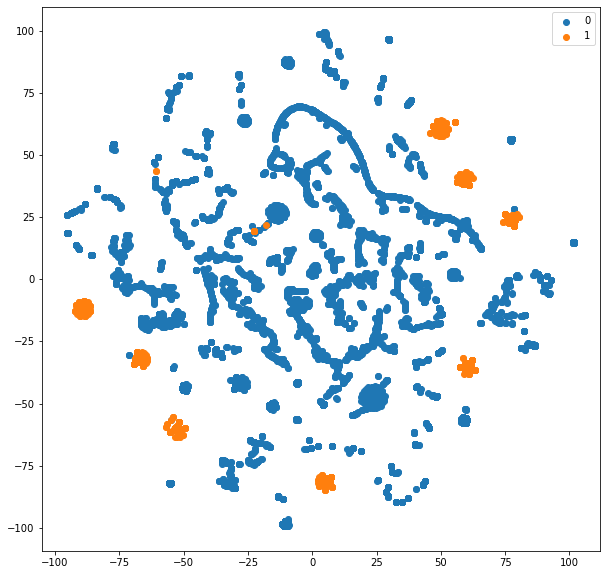

In [51]:
plot_tSNE(y_te,x_tsne3)

In [52]:
layers = [layer.output for layer in model.layers]

In [71]:
model.layers[2]

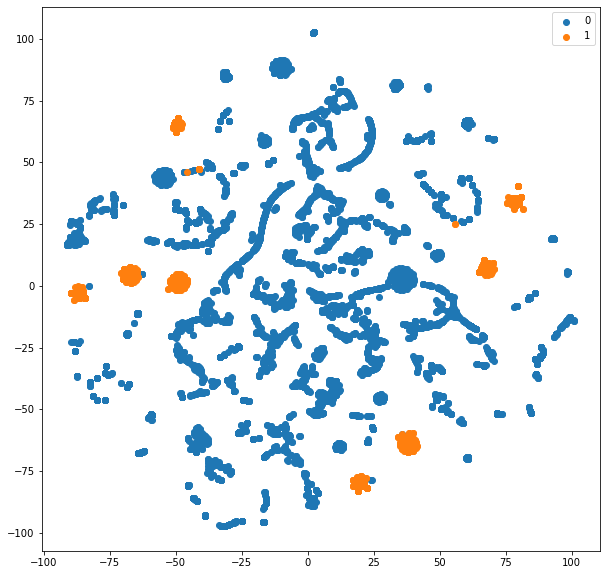

In [54]:
x_tsne17 = TSNE(n_components=2).fit_transform(activations[17]) 
plot_tSNE(y_te,x_tsne17)

In [65]:
import tensorflow as tf
import tensorflow.keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [66]:
X_te = test_data.x
A_te = test_data.a
y_te = test_data.y

y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])
print(f1(y_te, y_pred))

tf.Tensor([0.73578835], shape=(1,), dtype=float32)


In [67]:
activations

[array([[ 1.2626263e-03,  1.1595879e-10, -1.4374677e-35,  3.2813635e-19],
        [ 1.2626263e-03,  1.1595879e-10, -1.4374677e-35,  3.2813635e-19],
        [ 1.2626263e-03,  1.1595879e-10, -1.4374677e-35,  3.2813635e-19],
        ...,
        [ 6.5909094e-01,  1.5686275e-02,  6.5633488e-19,  0.0000000e+00],
        [ 6.5277779e-01,  3.9215689e-03,  3.2813637e-19,  0.0000000e+00],
        [ 6.5909094e-01,  1.3725491e-02,  6.5630381e-19,  0.0000000e+00]],
       dtype=float32),
 array([[0.        , 0.        , 0.0143796 , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.0143796 , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.0143796 , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.0791564 , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.07684526, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.   

In [68]:
len(activations)

22

In [69]:
len(model.layers)

22

2


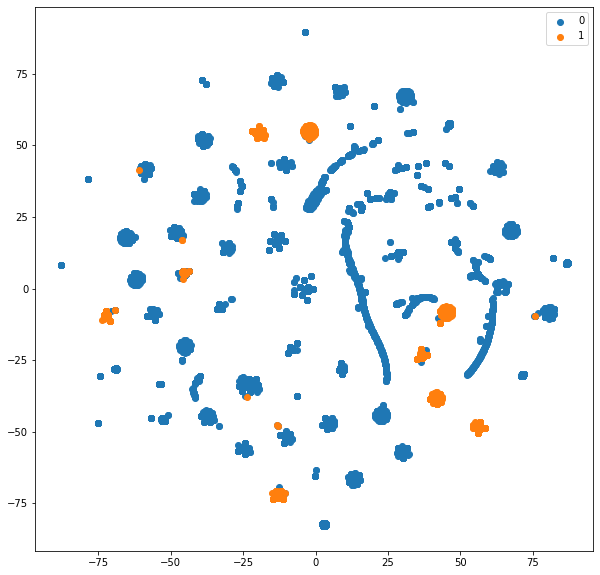

5


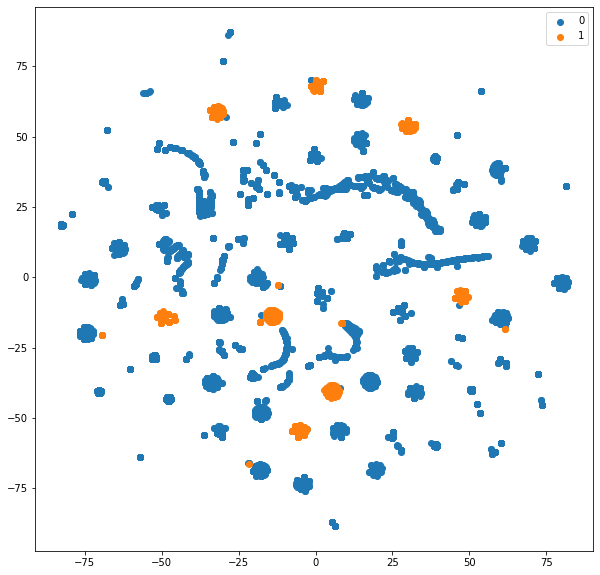

8


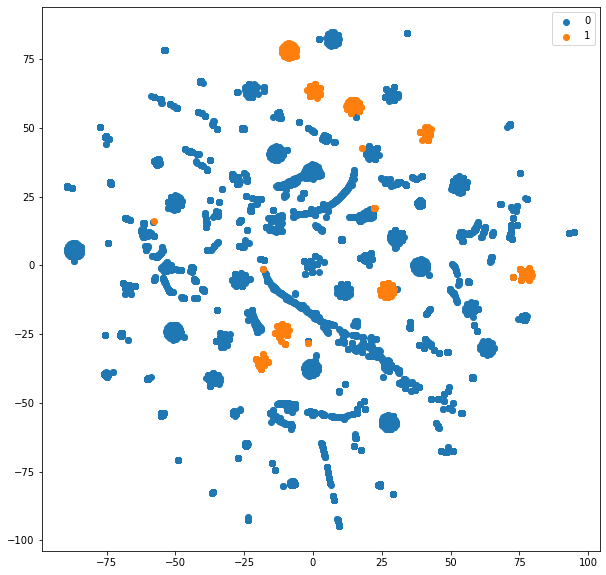

11


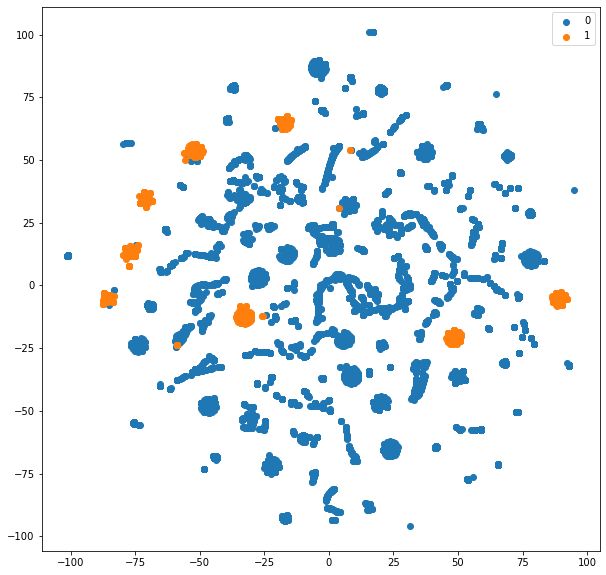

14


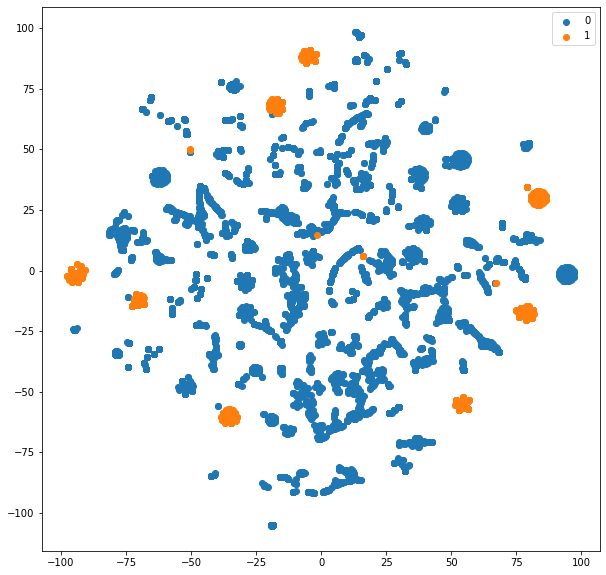

17


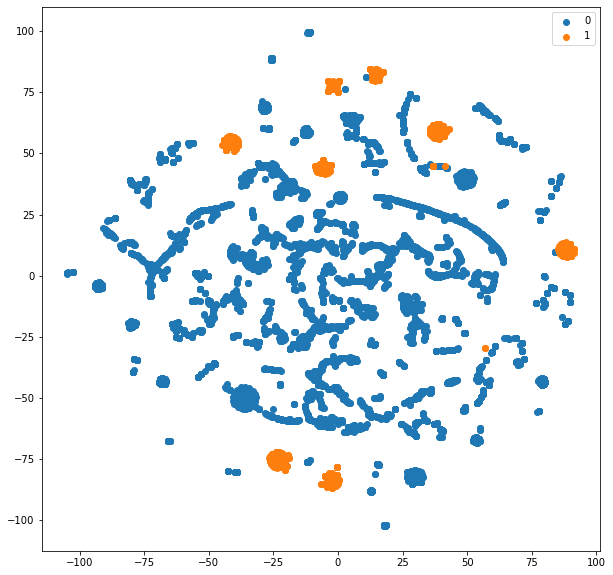

21


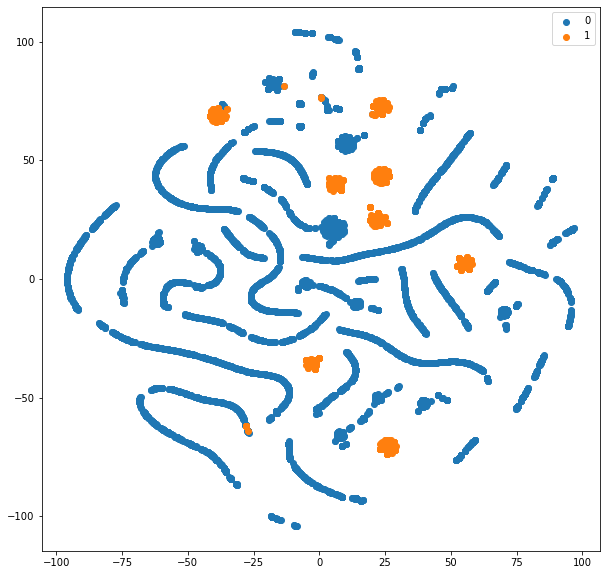

In [72]:
for i, layer in enumerate(model.layers):
    if isinstance(layer, ChebConv):
        print(i)
        x_tsne17 = TSNE(n_components=2).fit_transform(activations[i]) 
        plot_tSNE(y_te,x_tsne17)

In [76]:
from sklearn.manifold import TSNE
test_data = dataset_te[0]
X_te = test_data.x
A_te = test_data.a
y_te = test_data.y

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X_te,A_te, A_te],batch_size=X_te.shape[0])


2


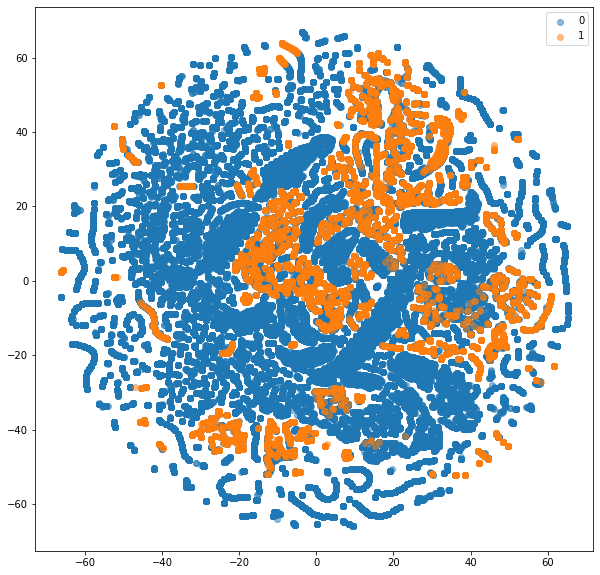

5


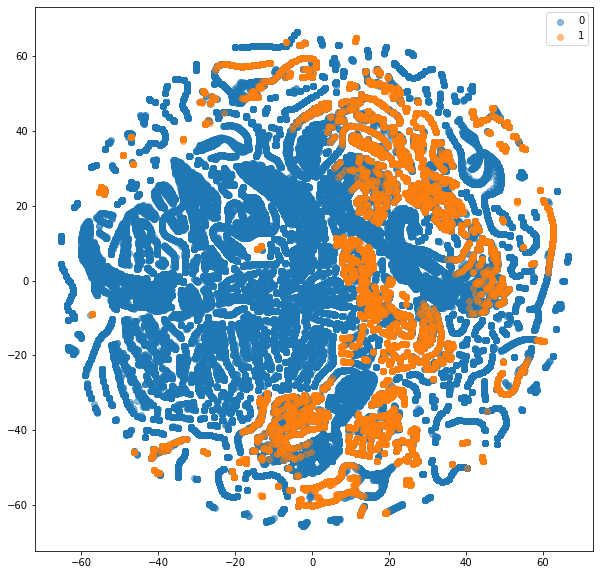

8


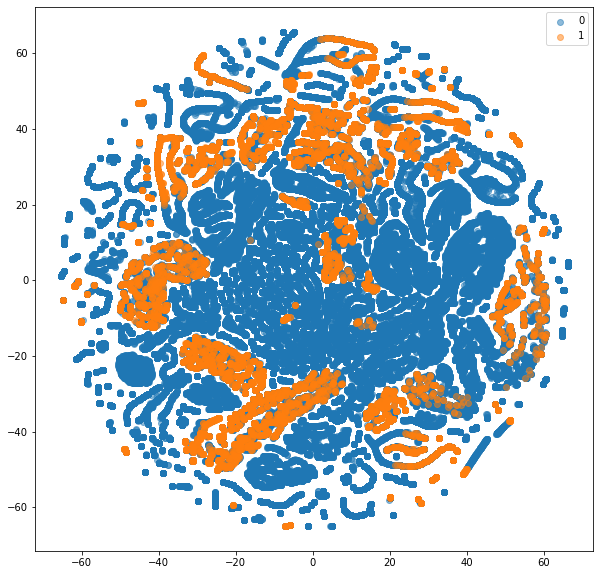

11


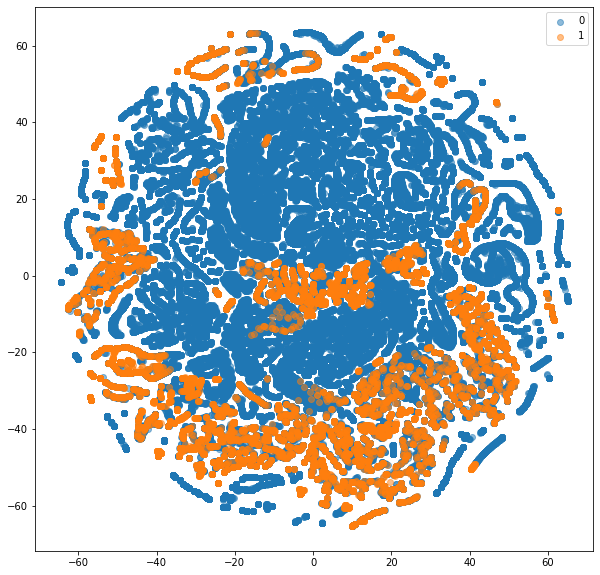

14


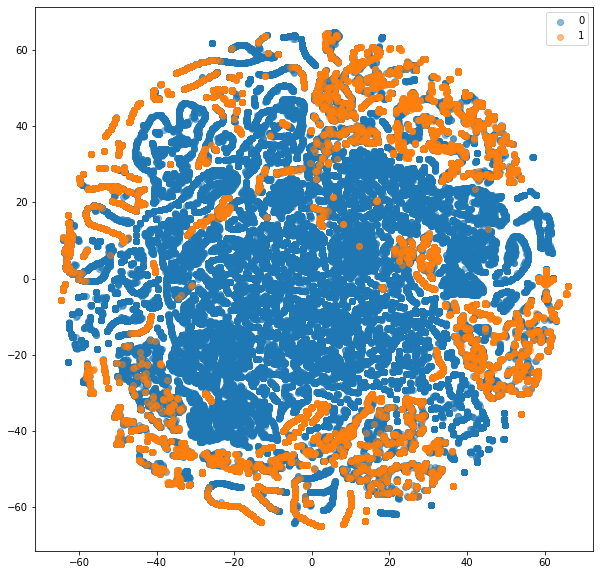

17


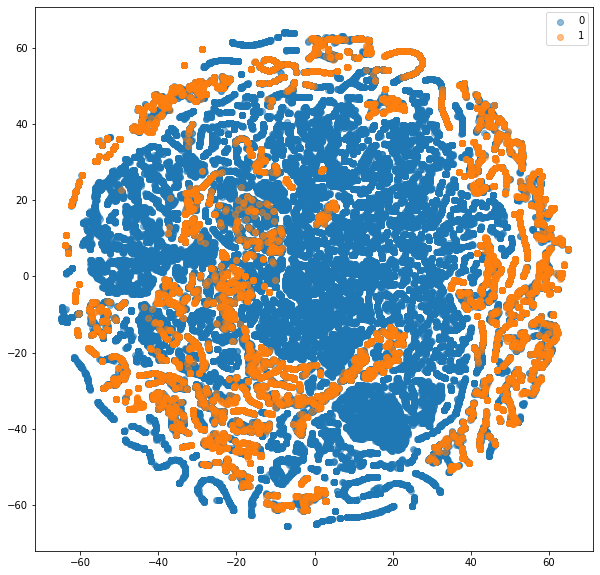

21


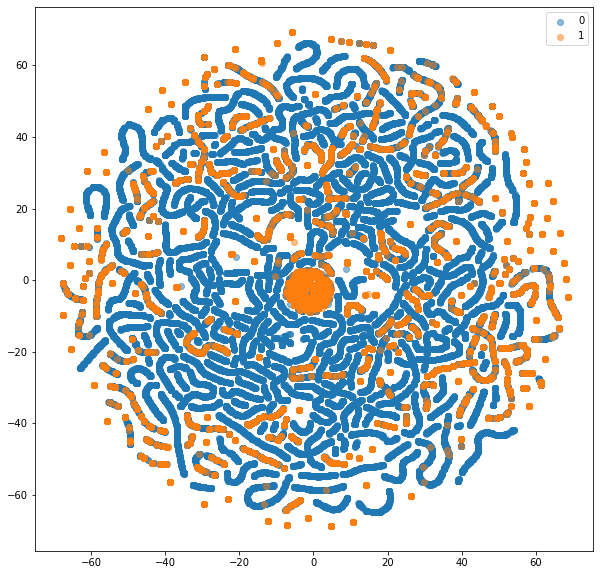

In [77]:
for i, layer in enumerate(model.layers):
    if isinstance(layer, ChebConv):
        print(i)
        x_tsne17 = TSNE(n_components=2).fit_transform(activations[i]) 
        plot_tSNE(y_te,x_tsne17)

In [100]:
import numpy as np
from sklearn import metrics


# for test_data in dataset_te:
test_data=dataset_te[0]
X_te = test_data.x
A_te = test_data.a
y_te = test_data.y
y_pred = model.predict([X_te, A_te, A_te],batch_size=X_te.shape[0])

# fpr, tpr, thresholds = metrics.roc_curve(y_te, y_pred)

In [101]:
test_data=dataset_te[1]
X_te = test_data.x
A_te = test_data.a
y_te = test_data.y
y_pred1 = model.predict([X_te, A_te, A_te],batch_size=X_te.shape[0])

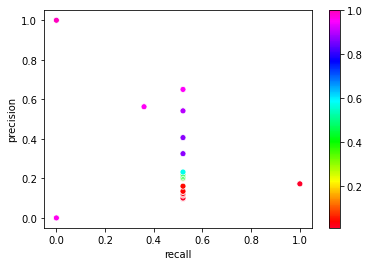

In [88]:
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve
from matplotlib import pyplot

precision, recall, thre = precision_recall_curve(y_te, y_pred)
thres = thre.tolist() + [1]
df_prec = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thres})
ax = sns.scatterplot(data=df_prec, x="recall", y="precision", hue="threshold", palette='gist_rainbow')

norm = plt.Normalize(min(thres), max(thres))
sm = plt.cm.ScalarMappable(cmap="gist_rainbow", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

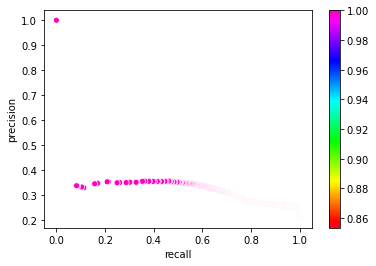

In [102]:
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve
from matplotlib import pyplot

precision, recall, thre = precision_recall_curve(y_te, y_pred1)
thres = thre.tolist() + [1]
df_prec = pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thres})
ax = sns.scatterplot(data=df_prec, x="recall", y="precision", hue="threshold", palette='gist_rainbow')

norm = plt.Normalize(min(thres), max(thres))
sm = plt.cm.ScalarMappable(cmap="gist_rainbow", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()